# 分析负载中的周期性


## AzureFunction 2021

In [1]:
# 我们已经处理好了每一个函数的负载数据，现在我们来分析一下这些数据的周期性
from smart_pred.dataset.azure_trace_2021 import AzureFunction2021

In [2]:
dataset = AzureFunction2021()
dataset.init()

In [3]:
app_list = dataset.get_app_list()

In [4]:
from py_plotter.plot import Plotter

my_plotter = Plotter(
    figsize=(20,6),
    fontsize=30,
)

In [5]:
def plot_trace_with_app(app_name, output_dir="./output"):
    # 先创建一个output_dir
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 在output_dir下创建一个app_name的文件夹
    if not os.path.exists(f'{output_dir}/{app_name}'):
        os.makedirs(f'{output_dir}/{app_name}')
    
    for function in dataset.get_function_list_by_app(app_name):
        # 获取trace
        trace = dataset.get_app_function_avg_concurrency_in_sec_list(app_name=app_name, function_name=function)
        
        # 在app_name下创建一个function_name的文件夹
        if not os.path.exists(f'{output_dir}/{app_name}/{function}'):
            os.makedirs(f'{output_dir}/{app_name}/{function}')

        # 分别画14天中的每一天的
        for day in range(14):
            # 画图
            x = [i for i in range(24*60*60)]
            y = trace[day*24*60*60:(day+1)*24*60*60]
            line_data_list = []
            x_list = []
            x_list.append(x)
            line_data_list.append(y)
            
            save_name = f"{function}-{day}.pdf"
            save_root = f'{output_dir}/{app_name}/{function}'
            
            my_plotter.plot_lines(
                x_list=x_list,
                x_tick_ndigits=0,
                y_tick_ndigits=1,
                line_data_list=line_data_list,
                legend_title=None,
                legend_label_list=["ts"],
                x_label='Timestamp (s) in a day',
                y_label='Concurrency',
                title=None,
                save_root=save_root,
                filename=save_name,
            )
            
            print(f"save to {save_root}")
        
        

In [6]:
# 画前5个app的
for app in app_list[:5]:
    plot_trace_with_app(app_name=app, output_dir="./output/azure_function_2021")

pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/7d37cefc5c5fd0c861664e80fed91c786518aa3635b855890c1a53c01700158c.pickle 存在，直接读取
图片保存到:./output/azure_function_2021/7d37cefc5c5fd0c861664e80fed91c786518aa3635b855890c1a53c01700158c/8e88f42ec8c23fe44f8bad6c720351f21e56770ccd6b420e47796c9086a1d705/8e88f42ec8c23fe44f8bad6c720351f21e56770ccd6b420e47796c9086a1d705-0.pdf
save to ./output/azure_function_2021/7d37cefc5c5fd0c861664e80fed91c786518aa3635b855890c1a53c01700158c/8e88f42ec8c23fe44f8bad6c720351f21e56770ccd6b420e47796c9086a1d705
图片保存到:./output/azure_function_2021/7d37cefc5c5fd0c861664e80fed91c786518aa3635b855890c1a53c01700158c/8e88f42ec8c23fe44f8bad6c720351f21e56770ccd6b420e47796c9086a1d705/8e88f42ec8c23fe44f8bad6c720351f21e56770ccd6b420e47796c9086a1d705-1.pdf
save to ./output/azure_function_2021/7d37cefc5c5fd0c861664e80fed91c786518aa3635b855890c1a53c01700158c/8e88f42ec8c23fe44f8bad6c720351f21e56770ccd6b42

In [7]:
# 筛选最大concurency=1的function
def get_max_concurency_function(max_concurency=1):
    # 先获取全部的function_list
    function_list = dataset.get_function_list()
    
    # 然后筛选
    
    result_dict_list = []
    for function in function_list:
        dataset.get_app_by_function(function_name=function)
        app_name = dataset.get_app_by_function(function_name=function)
        trace = dataset.get_app_function_avg_concurrency_in_sec_list(app_name=app_name, function_name=function)
        if max(trace) == max_concurency:
            print(f"{function} has max concurency {max_concurency}")
            # 找到该function的app_name
            
            
            result_dict = {
                "app_name": app_name,
                "function_name": function,
                "max_concurency": max_concurency,
            }
            result_dict_list.append(result_dict)
            
    return result_dict_list        

In [8]:

def find_function_name_list_with_max_concurency_in_range(cmax_min=4, cmax_max=4):
    # 先获取全部的function_list
    function_list = dataset.get_function_list()
    # 然后筛选
    result_dict_list = []
    for function in function_list:
        dataset.get_app_by_function(function_name=function)
        app_name = dataset.get_app_by_function(function_name=function)
        trace = dataset.get_app_function_avg_concurrency_in_sec_list(app_name=app_name, function_name=function)
        max_concurency = max(trace)
        if max(trace) >= cmax_min and max(trace) <= cmax_max:
            print(f"{function} has max concurency {max_concurency}")
            # 找到该function的app_name
            result_dict = {
                "app_name": app_name,
                "function_name": function,
                "max_concurency": max_concurency,
            }
            result_dict_list.append(result_dict)
    
    # 最大concurency=1的function的app_name一共
    len(result_dict_list)
    
    # 从result_dict_list中获取function_name_list
    function_name_list = [result_dict["function_name"] for result_dict in result_dict_list]
    
    # 保存为txt
    filename = f"./output/azure_function_2021/max_concurency_{cmax_min}_{cmax_max}_function_name_list.txt"
    with open(filename, "w") as f:
        for function_name in function_name_list:
            f.write(f"{function_name}\n")

In [9]:
find_function_name_list_with_max_concurency_in_range(cmax_min=5, cmax_max=1000)

pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/93b7777259b0d610403b21ed616ee883c5a42f3aaf0e449a4cf00258ea2f6197.pickle 存在，直接读取
pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/18ed3ca44bd1f7d411f1d047ed8cf38853fb184196afa59e91e68e5d06fda834.pickle 存在，直接读取
pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/a9fd6223e00378edd60a03c721f9345f34d198757a4057b349d0e85e3aa111b2.pickle 存在，直接读取
pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/1c5682a8e57d04d0399b33a181f549eae87392cb3b013b1d2b1035ba95be4ac0.pickle 存在，直接读取
pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/85479ef37b5dc75

In [10]:
# 一共的function数目
len(dataset.get_function_list())

424

In [11]:
# 一共的app数目
len(dataset.get_app_list())

119

In [20]:
def plot_trace_with_function(function_name, output_dir="./output/function"):
    # 先创建一个output_dir
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 在output_dir下创建一个function_name的文件夹
    if not os.path.exists(f'{output_dir}/{function_name}'):
        os.makedirs(f'{output_dir}/{function_name}')
        # get app_name
        app_name = dataset.get_app_by_function(function_name=function_name)
    
        # 获取trace
        trace = dataset.get_app_function_avg_concurrency_in_sec_list(app_name=app_name, function_name=function_name)

        # 分别画14天中的每一天的
        for day in range(14):
            # 画图
            x = [i for i in range(24*60*60)]
            y = trace[day*24*60*60:(day+1)*24*60*60]
            line_data_list = []
            x_list = []
            x_list.append(x)
            line_data_list.append(y)
            
            save_name = f"{function_name}-{day}.pdf"
            save_root = f'{output_dir}/{function_name}'
            
            my_plotter.plot_lines(
                x_list=x_list,
                x_tick_ndigits=0,
                y_tick_ndigits=1,
                line_data_list=line_data_list,
                legend_title=None,
                legend_label_list=["ts"],
                x_label='Timestamp (s) in a day',
                y_label='Concurrency',
                title=None,
                save_root=save_root,
                filename=save_name,
            )
            
            print(f"save to {save_root}")

In [22]:
# 画 5-1000的 function plot_trace_with_app(app_name=app, output_dir="./output/azure_function_2021")
txt_path = "~/GitHubProjects/smart-pred/measurement/trace_analysis/output/azure_function_2021/max_concurency_5_1000_function_name_list.txt"
# 转换为绝对路径
import os
txt_path = os.path.expanduser(txt_path)
# 读取txt
with open(txt_path, "r") as f:
    function_name_list = f.readlines()
    function_name_list = [function_name.strip() for function_name in function_name_list]
    
for function_name in function_name_list:
    plot_trace_with_function(function_name=function_name, output_dir="./output/azure_function_2021/max_concurency_5_1000_function")

pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/fc4cdb6f79037e080699671080a27ffce1be75872c1cd39107a0ec92969a5f89.pickle 存在，直接读取
图片保存到:./output/azure_function_2021/max_concurency_5_1000_function/93002245db03177e592d0d08879dc855579cf7005733e2c66af36f1fe6221594/93002245db03177e592d0d08879dc855579cf7005733e2c66af36f1fe6221594-0.pdf
save to ./output/azure_function_2021/max_concurency_5_1000_function/93002245db03177e592d0d08879dc855579cf7005733e2c66af36f1fe6221594
图片保存到:./output/azure_function_2021/max_concurency_5_1000_function/93002245db03177e592d0d08879dc855579cf7005733e2c66af36f1fe6221594/93002245db03177e592d0d08879dc855579cf7005733e2c66af36f1fe6221594-1.pdf
save to ./output/azure_function_2021/max_concurency_5_1000_function/93002245db03177e592d0d08879dc855579cf7005733e2c66af36f1fe6221594
图片保存到:./output/azure_function_2021/max_concurency_5_1000_function/93002245db03177e592d0d08879dc855579cf7005733e2c66af

In [23]:
# 画 2的 function plot_trace_with_app(app_name=app, output_dir="./output/azure_function_2021")
txt_path = "~/GitHubProjects/smart-pred/measurement/trace_analysis/output/azure_function_2021/max_concurency_2_function_name_list.txt"
# 转换为绝对路径
import os
txt_path = os.path.expanduser(txt_path)
# 读取txt
with open(txt_path, "r") as f:
    function_name_list = f.readlines()
    function_name_list = [function_name.strip() for function_name in function_name_list]
    
for function_name in function_name_list:
    plot_trace_with_function(function_name=function_name, output_dir="./output/azure_function_2021/max_concurency_2_function")

pickle文件 /Users/wzj/GitHubProjects/smart-pred/datasets/AzureFunctionsInvocationTraceForTwoWeeksJan2021/avg_concurrency_in_sec_by_app/fcc7dff74ceb0debf03599051a7772fc8f7749b80d03bd4ac1f65abeab162855.pickle 存在，直接读取
图片保存到:./output/azure_function_2021/max_concurency_2_function/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723-0.pdf
save to ./output/azure_function_2021/max_concurency_2_function/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723
图片保存到:./output/azure_function_2021/max_concurency_2_function/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723-1.pdf
save to ./output/azure_function_2021/max_concurency_2_function/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723
图片保存到:./output/azure_function_2021/max_concurency_2_function/102992e9e972d134ec0139cff7bfa30e972fd7ab90823cbf9c67c8f28ee07723/102992e9e97

# HUAWEI

In [9]:
from smart_pred.dataset.huawei import HuaweiPrivateDataset, HuaweiPublicDataset

huawei_private_dataset = HuaweiPrivateDataset()

huawei_public_dataset = HuaweiPublicDataset()

In [10]:
trace_data = huawei_private_dataset.get_data_by_day_range(
    start_day=0,
    end_day=4,
    function_name="4",
    resolution="minute",
    data_type="requests",
)
# 对 nan 进行填充 为0， list   
trace_data = [0 if str(x) == "nan" else x for x in trace_data]


图片保存到:./output/huawei/test.pdf


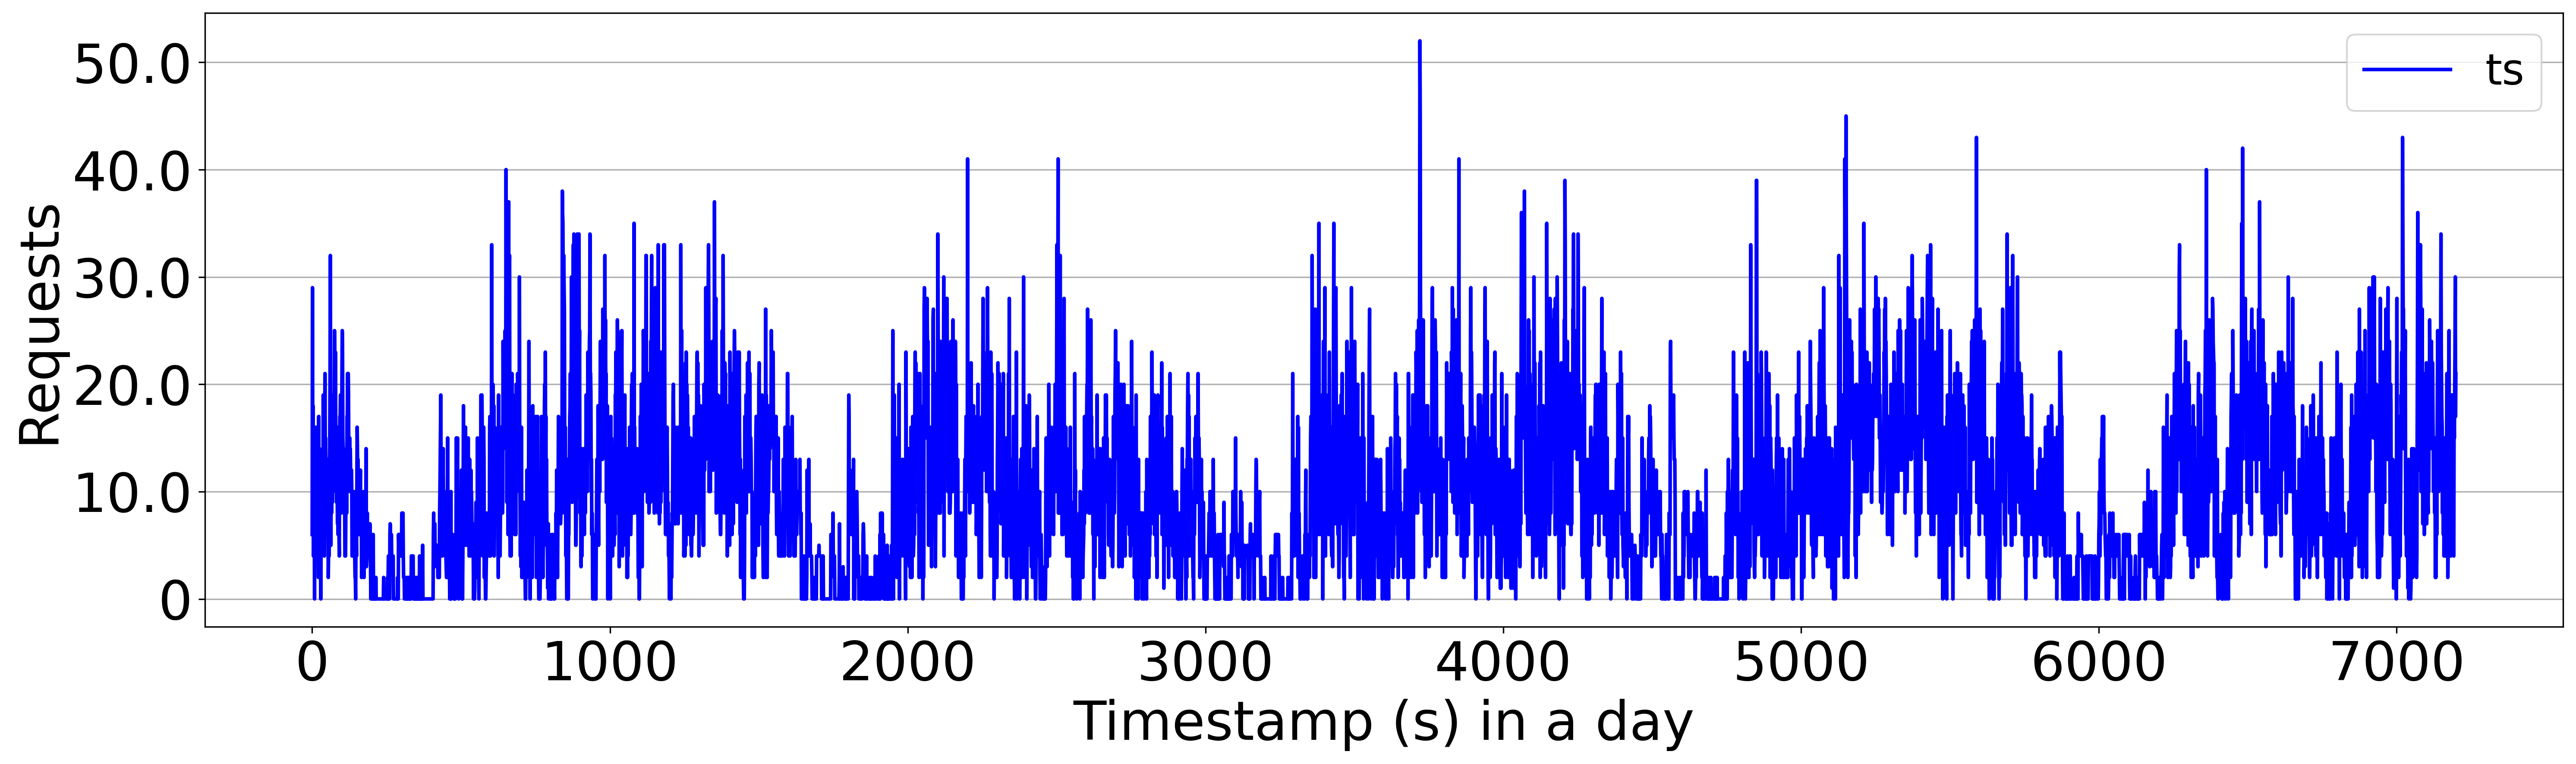

In [11]:
from py_plotter.plot import Plotter

my_plotter = Plotter(
    figsize=(20,6),
    fontsize=30,
)

line_data_list = []

# 一条曲线对应 line_data_list中的一个元素

y = trace_data
x = [i for i in range(len(y))]

my_plotter.plot_lines(
    x_list=[x],
    x_tick_ndigits=0,
    y_tick_ndigits=1,
    line_data_list=[y],
    legend_title=None,
    legend_label_list=["ts"],
    x_label='Timestamp (s) in a day',
    y_label='Requests',
    title=None,
    save_root="./output/huawei",
    filename="test.pdf",
    is_show=True,
)


In [12]:
# 用前0-10天作为训练集，第11天作为测试集
trace_data_train = huawei_private_dataset.get_data_by_day_range(
    start_day=0,
    end_day=10,
    function_name="4",
    resolution="minute",
    data_type="requests",
)

trace_data_test = huawei_private_dataset.get_data_by_day_range(
    start_day=11,
    end_day=11,
    function_name="4",
    resolution="minute",
    data_type="requests",
)

# 对 nan 进行填充 为0， list
trace_data_train = [0 if str(x) == "nan" else x for x in trace_data_train]
trace_data_test = [0 if str(x) == "nan" else x for x in trace_data_test]


In [13]:
# 初始化模型
from smart_pred.model.local import fourier, period, passive
from smart_pred.model.local import neuralforecast_model

#my_model = fourier.Crane_dsp_model()
#my_model = fourier.Icebreaker_model()
#my_model = period.Maxvalue_model()
#my_model = passive.Movingavg_model()
my_model = neuralforecast_model.NeuralForecast_model()


初始化 NHITS!


In [14]:
# 先train
extra_params = {
    "seq_len": 1440*3,
    "pred_len": 1440,
    "max_steps": 5000,
    "is_scaler": False,
    "is_round": False,
}
my_model.train(history=trace_data_train, extra_parameters=extra_params)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
# 再predict
prediction = my_model.predict(history=trace_data_train, predict_window=1440)

Predicting: |          | 0/? [00:00<?, ?it/s]

1440
1440


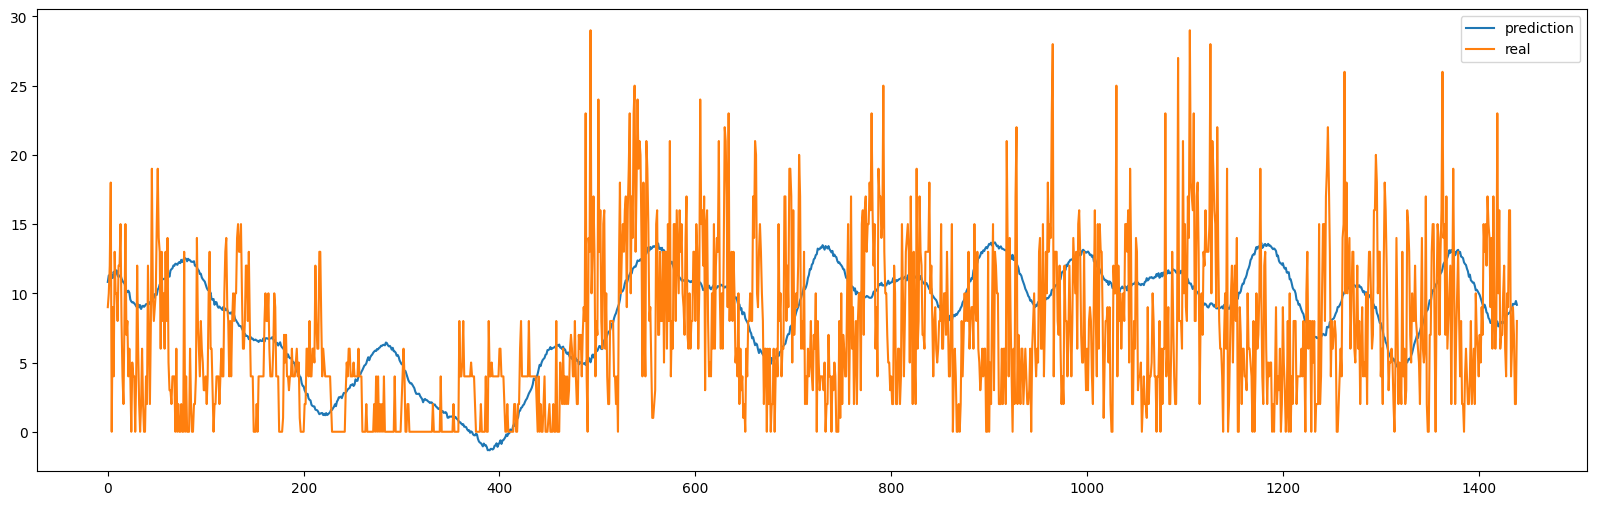

In [18]:
# 画出预测结果
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))

# print(len)
len_prediction = len(prediction)
len_test = len(trace_data_test)

print(len_prediction)
print(len_test)

x = [i for i in range(len_prediction)]
y = prediction
plt.plot(x, y, label="prediction")

# plot real
x = [i for i in range(len_test)]
y = trace_data_test
plt.plot(x, y, label="real")

plt.legend()
plt.show()



# 现在要找到调用比较频繁的function

In [1]:
from smart_pred.dataset.huawei import HuaweiPrivateDataset, HuaweiPublicDataset

# huawei_private_dataset day 000 到 234
huawei_private_dataset = HuaweiPrivateDataset()



# huawei_public_dataset day 00 到 25
huawei_public_dataset = HuaweiPublicDataset()

In [4]:
len(huawei_private_dataset.get_all_function_name())

200

In [5]:
len(huawei_public_dataset.get_all_function_name())

5093

In [ ]:
# 分别统计每个function的总请求数
function_name_list = huawei_private_dataset.get_all_function_name()

function_request_count_dict = {}
for function_name in function_name_list:
    trace_data = huawei_private_dataset.get_data_by_day_range(
        start_day=0,
        end_day=14,
        function_name=function_name,
        resolution="minute",
        data_type="requests",
    )
    # 对 nan 进行填充 为0， list
    trace_data = [0 if str(x) == "nan" else x for x in trace_data]
    function_request_count_dict[function_name] = sum(trace_data)
